# Graph Mining
## Graph Extraction
Extract the citations graph and author -> paper graph

In [38]:
import pandas as pd
df_compdata_ref_auth = pd.read_csv('../data/compdata_ref_author.csv')

In [39]:
df_compdata_ref_auth.head(1)

,Unnamed: 0,title,abstract,journal,DOI,date,collection,published,nauthors,topic.Healthcare,...,numcit,influcit,DL_Pdf,DL_Full,DL_Abstract,ref,authorsId,authorsNames,p_doi,p_journal
0,22,"Multivariate analysis of CT imaging, laborator...",PURPOSE: To develop and externally validate a ...,Abdom Radiol (NY),33098478,2020-10-25,pubmed,NaN,6,0.000988,...,0,0,NaN,NaN,NaN,"10.5152/TJAR.2014.83436, 10.1159/000509274, 10...","4593769, 2001055410, 2001050867, 16053632, 144...","S. Hectors, Sadjad Riyahi, Hreedi Dev, K. Kris...",10.1007/s00261-020-02823-w,Abdominal Radiology


In [40]:
# Generate edge_list
import numpy as np
# get reference dict
doi2ref = dict()
for idx in df_compdata_ref_auth.index:
    doi2ref[df_compdata_ref_auth['p_doi'].loc[idx]] = df_compdata_ref_auth['ref'].loc[idx]

# get edge_list and write to file
edge_list = list()
f = open("doi_links.csv", "w")
for k in doi2ref.keys():
    if type(doi2ref[k]) is float : ## handle nan values
        continue
    
    for val in doi2ref[k].split(', '):
        if val =='NA': # ignore NA values of papers
            continue
        print(k + ',' + val, file=f)
        edge_list.append((k, val))
    
f.close()

edge_list[1]

('10.1007/s00261-020-02823-w', '10.1159/000509274')

## PageRank using directed graph

In [41]:
import networkx as nx

G = nx.DiGraph()
G.add_edges_from(edge_list)

In [5]:
import matplotlib.pylab as plt

#plt.figure()
#plt.rcParams['figure.figsize'] = [10, 10]

#pos = nx.spring_layout(G)
#nx.draw_networkx_nodes(G, pos)
#nx.draw_networkx_edges(G, pos, edgelist=edge_list, arrows=True)

#plt.show()

In [5]:
import networkx as nx 
pr=nx.pagerank(G,0.9) 

In [6]:
prob = list()
for idx in df_compdata_ref_auth.index:
    if df_compdata_ref_auth['p_doi'].loc[idx] in pr.keys():
        prob.append(pr[df_compdata_ref_auth['p_doi'].loc[idx]])
    else:
        prob.append(0)

In [7]:
len(prob)

5758

In [8]:
df_compdata_ref_auth['pgrank'] = pd.Series(prob)

In [9]:
df_compdata_ref_auth['pgrank'].describe()

count    5758.000000
mean        0.000012
std         0.000006
min         0.000000
25%         0.000014
50%         0.000014
75%         0.000014
max         0.000055
Name: pgrank, dtype: float64

In [10]:
df_compdata_ref_auth.to_csv('compdata_ref_auth_pgrank.csv')

In [22]:
df_emb = pd.read_csv('graph_embedding.csv', index_col=False)

## Load other features and targets

In [15]:
import pandas as pd
X = pd.read_csv('../data/lda_doc2vec_fts.csv', index_col=False)
y = pd.read_csv('../data/lda_doc2vec_targs.csv', index_col=False)
X = X.drop(X.columns[0], axis=1)
y = y.drop(y.columns[0], axis=1)

#X = X.apply (pd.to_numeric, errors='coerce')
X = X.fillna(0)
len(X)

5686

In [16]:
X.columns

Index(['title', 'abstract', 'journal', 'DOI', 'date', 'collection',
       'published', 'nauthors', 'topic.Healthcare', 'topic.Drug discovery',
       'topic.Epidemiology', 'topic.Clinics', 'topic.Chest X-Ray',
       'topic.Genomics', 'topic', 'numcit', 'influcit', 'DL_Pdf', 'DL_Full',
       'DL_Abstract', 'cit', 'cit_velocity', 'influential_cit', 'sum.npapers',
       'sum.infCit', 'mean.npapers', 'mean.infCit', 'max.npapers',
       'max.infCit', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5',
       'Topic 6', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35',
       '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47',
       '48', '49', 'pubmed', 'medrxiv', 'arxiv', 'biorxiv'],
      dtype='object')

In [17]:
y.value_counts()

0    
True     3329
False    2357
dtype: int64

In [18]:
import pandas as pd

pgrank = pd.read_csv('compdata_ref_auth_pgrank.csv', index_col=False)
pgrank_redup = pd.DataFrame(pgrank.drop_duplicates(subset=['title'])['pgrank'].tolist(), columns=['pgrank'])

In [23]:
X = pd.concat([X, df_emb,pgrank_redup], axis=1)
len(X)

5686

# Predict impact_factors

In [529]:
import pandas as pd

X_csv = pd.read_csv('../data/lda_doc2vec_fts.csv', index_col=False)
impact_f = pd.read_csv('impact_f.csv', index_col=False)

In [530]:
X_csv.columns

Index(['Unnamed: 0', 'title', 'abstract', 'journal', 'DOI', 'date',
       'collection', 'published', 'nauthors', 'topic.Healthcare',
       'topic.Drug discovery', 'topic.Epidemiology', 'topic.Clinics',
       'topic.Chest X-Ray', 'topic.Genomics', 'topic', 'numcit', 'influcit',
       'DL_Pdf', 'DL_Full', 'DL_Abstract', 'cit', 'cit_velocity',
       'influential_cit', 'sum.npapers', 'sum.infCit', 'mean.npapers',
       'mean.infCit', 'max.npapers', 'max.infCit', 'Topic 1', 'Topic 2',
       'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', '0', '1', '2', '3', '4',
       '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
       '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41',
       '42', '43', '44', '45', '46', '47', '48', '49', 'pubmed', 'medrxiv',
       'arxiv', 'biorxiv'],
      dtype='object')

In [531]:
X = pd.concat([X_csv, df_emb, impact_f['impact_f']], axis=1)

In [532]:
X_toprint['impact_f'] = X['impact_f']

In [533]:
X_truth = X[X['impact_f'].notnull()]
X_pred = X[~X['impact_f'].notnull()]

In [534]:
F_LDA = ['topic.Healthcare', 'topic.Drug discovery', 'topic.Epidemiology', 'topic.Clinics', 'topic.Chest X-Ray', 'topic.Genomics']
F_nauth = ['nauthors']
F_Doc2Vec =['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49']
F_gem = [ 'em ' + str(i+1) for i in range(128)]

In [535]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_truth, X_truth['impact_f'], test_size=0.2, random_state=123)

In [536]:
from sklearn.metrics import roc_curve, auc    
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


def XGBoost_Modeling(features):
    xg_reg = xgb.XGBRegressor(objective='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

    xg_reg.fit(X_train[features],y_train)

    preds = xg_reg.predict(X_test[features])    
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
   
    print("MAE is :" + str(mae) + ", MSE is :" + str(mse))
    return mae

In [537]:
mae_xgboost_LDA = XGBoost_Modeling(F_LDA + F_nauth)
mae_xgboost_Doc2Vec = XGBoost_Modeling(F_Doc2Vec + F_nauth)
mae_xgboost__gem = XGBoost_Modeling(F_gem + F_nauth)
#mae_xgboost_Doc2Vec_gem = XGBoost_Modeling(F_Doc2Vec_gem)
mae_xgboost_Doc2Vec_gem_nauth_LDA = XGBoost_Modeling(F_Doc2Vec_gem_nauth_LDA)

[18:25:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE is :2.8971111730496903, MSE is :44.564620655825934
[18:25:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE is :2.9077391227250247, MSE is :44.099256057919696
[18:25:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE is :2.8969763275962515, MSE is :42.98810181814042
[18:25:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE is :2.964707311728566, MSE is :47.077451978866236


[18:25:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


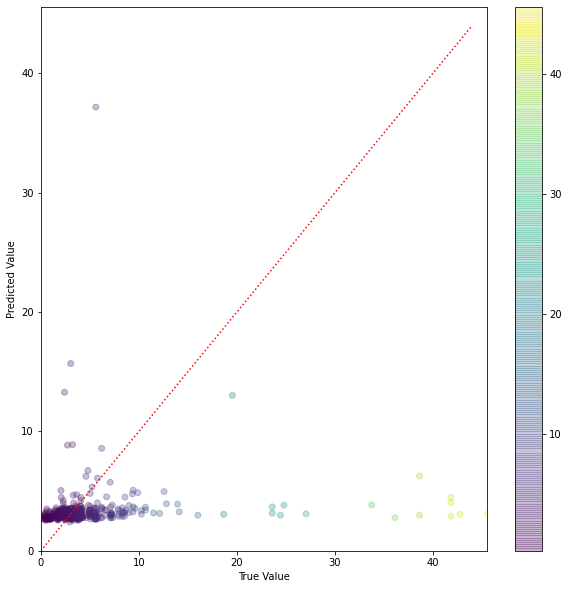

In [538]:
features = F_Doc2Vec_gem_nauth_LDA
xg_reg = xgb.XGBRegressor(objective='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train[features],y_train)

colors = y_test
preds = xg_reg.predict(X_test[features]) 

plt.scatter(y_test, preds, c=colors, alpha=0.3, cmap='viridis')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')

plt.plot(range(int(y_test.max(0))), range(int(y_test.max(0))), 'r:')

# set axes range
plt.xlim(0, y_test.max(0))
plt.ylim(0, y_test.max(0))
plt.colorbar();  # show color scale

In [539]:
features = F_LDA + F_Doc2Vec + F_gem
xg_reg = xgb.XGBRegressor(objective='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train[features],y_train)
test_pred = xg_reg.predict(X[features])    

[18:25:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [540]:
X_toprint['pred_if'] = test_pred
X_toprint.to_csv('Papers_pred_pubprob_if.csv')

In [541]:
X['pred_if'] = test_pred
X[['impact_f','pred_if']].head(30)

,impact_f,pred_if
0,2.429,4.644232
1,4.981,3.309205
2,6.551,3.432889
3,4.074,3.115140
4,4.986,2.999138
5,NaN,2.682000
6,2.190,2.879737
7,7.081,3.479312
8,2.490,2.865063
9,3.381,2.917404


In [542]:
X[['impact_f','pred_if']].tail(30)

,impact_f,pred_if
5656,NaN,2.682000
5657,NaN,4.542501
5658,NaN,3.444999
5659,NaN,4.745164
5660,NaN,3.271886
5661,NaN,3.284982
5662,NaN,3.387888
5663,NaN,2.682000
5664,NaN,3.383521
5665,NaN,3.935659
